In [1]:
# data preparation

In [2]:
import pandas as pd
import pickle
import pysal as ps
import geopandas as gpd
from geopandas import GeoDataFrame
import geopy
import xlrd
from ukpostcodeutils import validation
from scipy.special import ndtri
from scipy.stats import chi2
from math import sqrt
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from shapely.geometry import Point
from tqdm import tqdm
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm import tqdm
%matplotlib inline

/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [3]:
def prepare_mesothelioma_data(df):
    """
    prepares mesothelioma data by cleaning postcodes and adding count, agegroup, imd, 
    ruc, oac, lsoa, msoa, ward, lad
    """
    # overseas records lack a postcode
    overseas_records = [1205,1800,7903,23214,\
                    33311,35611,54008,55213,\
                    55413,58014,62213,63895,85200,92099,\
                    95407,102795,106395,131398,152415,\
                    161112,206109,240014,248415,137806, 173404]
    
    # discard overseas records
    df = df.loc[~df.HSE_ID.isin(overseas_records)].copy()

    # some records have incorrect postcodes
    record_corrections = {10507:'IV27 4NY', 16506:'S8 7RY', 
                     52806:'E11 1PS', 138802: 'NN11 9BJ',
                     13002:'DN2 5SU', 28197:'SE2 0DU', 
                     44101:'CM4 0DD', 52201:'W1U 4NY',
                     53610:'HS5 3TL', 120008:'DY10 3LT',
                     126202:'G81 5QR', 134196:'ST17 0XG',
                     174808:'IP2 0XA', 196708:'OL15 0JF',
                     114105:'NE23 8DT', 26496:'IG11 0BJ',
                     34904:'IV40 8AH',  46604: 'SW1V 3NA',  
                     52403:'BS232EN',  66398:'PL126AE',  
                     69698:'TQ4 6DG',  70399:'EX6 8PS', 
                     70499:'EX6 8EP',  70902:'DD10 9NE',
                     34904:'IV40 8AH',  46604: 'SW1V 3NA',  
                     52403:'BS2 32EN',  66398:'PL12 6AE',  
                     69698:'TQ4 6DG',  70399:'EX6 8EP',  
                     70499:'EX6 8EP',  70902:'DD10 9NE',
                     71699:'PL12 4EB',  79997:'PO12 1HA',  
                     82701:'KY10 2AP',  87302:'BN9 9AX',  
                     93598:'PA27 8DS',  96098:'KA28 0BZ', 
                     100904:'SO45 6HA', 104914:'EX39 2NF',
                     108296:'SA62 4HP', 109515:'BH23 1LN', 
                     116996:'PA20 9JZ', 121105:'PA20 9EH', 
                     121901:'CT10 1QD', 122913:'PO1 3AF', 
                     124012:'PO11 9RR', 127801:'LA4 5PS',
                     130306:'LA1 5PE', 134812:'PA23 8QT', 
                     137806:'BT36 6UX', 142612:'HU18 1EP', 
                     144513:'PO33 4JP', 166001:'SA73 3BP',     
                     147605:'KA30 8SF', 164501:'LL18 3NR', 
                     173404:'BT47 6NL', 174107:'BN43 5JF', 
                     183215:'NR26 8DX', 199012:'IP2 8RW', 
                     217610:'BN2 5TJ'}
    
    # correct incorrect postcodes
    df.POSTCODE.update(df.HSE_ID.map(lambda x: record_corrections.get(x)))    
    
    # create column for merging with ons postcode
    df['pcd'] = df['POSTCODE']
    
    # clean postcodes
    df['pcd'] = df['pcd'].str.replace(' ','')
    df['pcd'] = df['pcd'].str.replace('  ','')
    df['pcd'] = df['pcd'].str.upper()
    
    # since 1 row represents one death at present
    df['COUNT'] = 1 

    # over 90's become 90 because we only have pop data for 90+
    mask = df['AGE'] > 89
    df.loc[mask,'AGE'] = 90 
    df['AGEGRP'] = pd.cut(df.AGE, range(15,100,5), 
                    labels=[
                        '15 to 19',
                        '20 to 24',
                        '25 to 29',
                        '30 to 34',
                        '35 to 39',
                        '40 to 44',
                        '45 to 49',
                        '50 to 54',
                        '55 to 59',
                        '60 to 64',
                        '65 to 69',
                        '70 to 74',
                        '75 to 79',
                        '80 to 84',
                        '85 to 89',
                        '90 to 95'],
                    right=False)
    
    # we might want broader age groups too later; like <45, 45-64, 65+ (which this implements)
    age_lookup = {'15 to 19':0, '20 to 24':0, '25 to 29':0, '30 to 34':0, '35 to 39':0,
       '40 to 44':0, '45 to 49':1, '50 to 54':1, '55 to 59':1, '60 to 64':1,
       '65 to 69':2, '70 to 74':2, '75 to 79':2, '80 to 84':2, '85 to 89':2,
       '90 to 95':2}
    df['AGEGRP2'] = df['AGEGRP'].map(age_lookup)
    
    # merge on postcode to add X, Y, and lsoa11 and more from ons postcode directory file
    # https://data.gov.uk/dataset/dca79df3-2cf5-40b8-8b27-d0e0d3485077/ons-postcode-directory-latest-centroids
    # https://usermanual.wiki/Document/NSPL20User20Guide20May202018.1759225985.pdf
    df1 = pd.read_csv('ONS_Postcode_Directory_Latest_Centroids.csv', usecols=[0,1,3,45,46,50,51,52,53,59])
    df1['pcd'] = df1['pcd'].str.replace(' ','')
    df1['pcd'] = df1['pcd'].str.replace('  ','')
    df1['pcd'] = df1['pcd'].str.upper()
    df = pd.merge(df, df1, on='pcd')
    
    # merge with lookup file to add LSOA, ward, and lad
    lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
    df.rename(index=str, columns={"lsoa11": "LSOA11CD"}, inplace=True)
    df = pd.merge(df, lookup, on='LSOA11CD', how='left')
    
    # we're going to limit data to E&W and 2002-2015 because 
    # population data doesn't include Scotland 
    # and changes made to areas outside this timeframe
    df = df.loc[df['LSOA11CD'].str[:1] != 'S']
    # population data is from 2002
    df = df.loc[df.YOD > 2001] 
    
    # add urban or not
    urban_lookup = {'A1':1, 'B1':1, 'C1':1, 'C2':1, 'D1':0, 'D2':0, 'E1':0, 'E2':0, 'F1':0, 'F2':0}
    df['urban'] = df.ru11ind.map(urban_lookup)
    
    # add oac supergroup
    # https://www.ons.gov.uk/file?uri=/methodology/geography/geographicalproducts/areaclassifications/2011areaclassifications/penportraitsandradialplots/penportraits.pdf
    df['oacs'] = df['oac11'].str[:1].astype(int)
    
    # nameing consistency
    df.rename(index=str, columns={"msoa11": "MSOA11CD"}, inplace=True)

    # save result
    df.to_csv('mesomaps.csv', index=False)
    return(df)

In [4]:
def prepare_docks_geojson():
    # we use wget, the overpass api wizard, and osmtogeojson to obtain geojson goodness
    # wget -O- "https://overpass-api.de/api/interpreter?data=%2F*%0AThis%20has%20been%20generated%20by%20the%20overpass-turbo%20wizard.%0AThe%20original%20search%20was%3A%0A%E2%80%9Cdock%E2%80%9D%0A*%2F%0A%5Bout%3Ajson%5D%5Btimeout%3A250%5D%3B%0A%2F%2F%20gather%20results%0A%28%0A%20%20%2F%2F%20query%20part%20for%3A%20%E2%80%9Cdock%E2%80%9D%0A%20%20way%5B%22waterway%22%3D%22dock%22%5D%2847.21956811231547%2C-13.60107421875%2C59.4115481664237%2C9.07470703125%29%3B%0A%29%3B%0A%2F%2F%20print%20results%0Aout%20meta%20center%20qt%3B%0A" | osmtogeojson > docks.geojson
    gdf = gpd.read_file('docks.geojson')
    gdf.crs = {'init': 'epsg:4326'}

    # UK projection for the dockyards
    gdf = gdf.to_crs(epsg=27700)

    # we obtain a country boundary file from gov geoportal (the UK)
    c = gpd.read_file('country2.json')
    c.crs = {'init': 'epsg:4326'}

    # UK projection for the UK
    c = c.to_crs(epsg=27700)
    
    # England and Wales Map
    ew = c[c['ctry17nm'] != 'Scotland'] 

    # discard dockyards that aren't inside our country
    gdf = gpd.sjoin(gdf, c, how="inner", op='intersects')

    # lets not have borders inside our country so that distance to border == distance to coast
    # (there's an internal border between England and Wales)
    c = c.dissolve(by='extrude')

    # get rid of dockyards that aren't dockyards and lose dockyards that aren't within 5km of the coast
    gdf['dist_to_coast'] = gdf.geometry.map(lambda x: x.distance(c.geometry.iloc[0].boundary))
    gdf = gdf[gdf['dist_to_coast'] < 5000] 
    gdf = gdf[gdf['name'].str.contains('Marina|Weir|Quay|Harbour', na=False) == False]
    gdf = gdf[gdf['seamark:harbour:category'].str.contains('marina', na=False) == False]
    gdf = gdf[gdf['seamark:type'].str.contains('harbour', na=False) == False]
    gdf = gdf[gdf['leisure'].str.contains('marina', na=False) == False]
    
    # England and Wales only
    gdf = gdf[gdf['ctry17nm'] != 'Scotland'] 
    
    # LSOAs for docks is done by dockinarea and add_missing_lsoa_docks below
    
    # convert projections to 4326 now because that's what our dist to dock calculation would like 
    gdf = gdf.to_crs(epsg=4326)
    gdf.to_file('docks_edited.geojson') # save edited dockyards so can be used in dist_to_dock function
    
def docksinarea(area, areacd):
    """
    find docks from our preprepared list that are within
    geographic areas of our choosing (LSOA/MSOA/ward/LAD)
    """
    gdf = gpd.read_file('docks_edited.geojson')
    gdf = gdf.to_crs(epsg=4326)
    gdf.crs = {'init': 'epsg:4326'}
    located_docks = gpd.sjoin(gdf, area[[areacd, 'geometry']].copy(), op='within')
    n_docks_not_located = len(gdf[~gdf.name.isin(located_docks.name)])
    print("\n{} docks not located".format( n_docks_not_located))
    return located_docks

def add_missing_lsoa_docks(lsoadocks):
    """
    manually add geographic areas for docks that are not located
    as happens when for example the long/lat of a reported dock
    happen to lie outside of the area polygon.
    """
    located_docks = lsoadocks
    
    gdf = gpd.read_file('docks_edited.geojson')
    gdf = gdf.to_crs(epsg=4326)
    gdf.crs = {'init': 'epsg:4326'}
    
    # we manually add docks that failed to be located (cos their points weren't in the polygon)
    
    missing = gdf[~gdf.name.isin(located_docks.name)].copy()
 
    dock_lsoa_lookup = { "Hay's Wharf": 'E01004027',
                         'New Holland': 'E01013303',
                         'Glasson Dock': 'E01025107',
                         'Marshall Dock': 'E01019126',
                         'Greenfield Dock': 'W01000296'}

    missing.loc[:, 'LSOA11CD'] = missing.loc[:, 'name'].map(dock_lsoa_lookup)

    lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
    missing = pd.merge(missing, lookup.drop_duplicates(subset='LSOA11CD'), on='LSOA11CD')

    missing = missing[['timestamp', 'version', 'changeset', 'user', 'uid', 'name',
           'source', 'waterway', 'id', 'access_tid', 'landuse', 'natural',
           'seamark_ha', 'seamark_ty', 'wikidata', 'source_nam', 'source_geo',
           'dock', 'note', 'boat', 'leisure', 'phone', 'wikipedia',
           'alt_name', 'OnroerendE', 'heritage', 'heritage_o', 'heritage_w',
           'ref_Onroer', 'water', 'tidal', 'old_name', 'access_t_1', 'fax',
           'harbour', 'harbour_bo', 'harbour__1', 'harbour__2', 'harbour_ca',
           'harbour_ch', 'harbour_el', 'harbour_fu', 'harbour_la',
           'harbour_ph', 'harbour_pr', 'harbour_pu', 'harbour_re',
           'harbour_sh', 'harbour_to', 'harbour_vi', 'harbour_wa',
           'internet_a', 'internet_1', 'internet_2', 'operator', 'sanitary_d',
           'seamark_in', 'seamark_na', 'vhf_channe', 'website', 'addr_city',
           'bezier', 'descriptio', 'area', 'created_by', 'name_en',
           'building', 'lock', 'loc_name', 'ship', 'man_made', 'ref',
           'mooring', 'email', 'harbour_sc', 'layer', 'width', 'source_sha',
           'start_date', 'image', 'ref_rce', 'designatio', 'maxdraught',
           'maxlength', 'maxwidth', 'type', 'floating', 'name_gv', 'tourism',
           'architect', 'historic', 'info', 'surveillan', 'maxstay',
           'addr_stree', 'motorboat', 'mhs_inscri', 'ref_mhs', 'source_her',
           'access', 'covered', 'maxdraft', 'capacity', 'contact_ph',
           'harbour_in', 'index_righ', 'tessellate', 'extrude', 'visibility',
           'ctry17cd', 'ctry17nm', 'ctry17nmw', 'bng_e', 'bng_n', 'long',
           'lat', 'objectid', 'st_lengths', 'st_areasha', 'dist_to_co',
           'geometry', 'LSOA11CD']]

    del located_docks['index_right']
    located_docks = pd.concat([located_docks, missing])
    
    n_docks_not_located = len(gdf[~gdf.name.isin(located_docks.name)])
    
    print("\n*missing docks added* now {} docks not located".format( n_docks_not_located))
    return located_docks

def prepare_docks_data():
    """
    prepare a dataframe of our docks data that includes 
    LSOAs, MSOAs, wards and LADS for all docks
    """
    prepare_docks_geojson()
    lsoa = gpd.read_file('lsoa.json')
    lsoa.crs = {'init': 'epsg:4326'}
    lsoa.rename(index=str, columns={"lsoa11cd": "LSOA11CD"}, inplace=True)

    area = lsoa
    areacd = 'LSOA11CD'
    lsoadocks = docksinarea(area, areacd)
    lsoadocks = add_missing_lsoa_docks(lsoadocks)

    # checking docks we have against our geojson 4 are missing
    # we have to add manually (this is a bug)
    gdf = gpd.read_file('docks_edited.geojson')
    gdf = gdf.to_crs(epsg=4326)
    gdf.crs = {'init': 'epsg:4326'}
    missing = gdf[~gdf.id.isin(lsoadocks.id)].copy()
    missing.loc[42,'LSOA11CD'] = 'E01021057'
    missing.loc[43,'LSOA11CD'] = 'E01021047'
    missing.loc[114,'LSOA11CD'] = 'E01013136'
    missing.loc[180,'LSOA11CD'] = 'E01033104'
    docks = pd.concat([lsoadocks, missing])
    
    lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
    docks = pd.merge(docks, lookup, on='LSOA11CD')  # now each dock has lsoa, ward, and lad
    
    # add msoa
    lsoa_to_msoa_lookup = pd.read_csv('Output_Area_to_Lower_Layer_Super_Output_Area_to_Middle_Layer_Super_Output_Area_to_Local_Authority_District_December_2017_Lookup_in_Great_Britain__Classification_Version_2.csv')
    lsoa_to_msoa_lookup.index = lsoa_to_msoa_lookup['LSOA11CD']
    lsoa_to_msoa_lookup = lsoa_to_msoa_lookup['MSOA11CD'].to_dict()
    docks['MSOA11CD'] = docks['LSOA11CD'].map(lsoa_to_msoa_lookup)
    return docks

In [5]:
def dist_to_dockyards(df):
    """
    calculate distance to nearest dockyard and add it to our dataframe
    """
    # make our dataframe be a geodataframe and give it some correctly formatted coordinates
    # for our dock calculation
    # this is probably not an optimal approach wrt efficiency
    df['Coordinates'] = list(zip(df.X, df.Y))
    df['geometry'] = df['Coordinates'].apply(Point)
    crs = {'init': 'epsg:4326'}
    df = GeoDataFrame(df, crs=crs)
    df['coords'] = list(zip(df.geometry.y, df.geometry.x)) # note x and y order
    df['disttodock'] = df.apply(dist_to_dock, axis=1)
    
    # save the result
    df.to_csv('mesomaps_with_disttodock.csv')
    return df

def dist_to_dock(x): 
    """
    calculate distance from point to nearest dock
    """
    gdf = gpd.read_file('docks_edited.geojson')
    gdf['coords'] = list(zip(gdf.geometry.y, gdf.geometry.x)) # note x and y order
    
    distance = []
    for coord in gdf['coords'].values:
        distance.append(geopy.distance.vincenty(x.coords, coord).km)
    return min(distance)

In [6]:
# df = pd.read_excel('20171003_Data_for_Carl.xlsx') # data provided by HSE
# df = prepare_mesothelioma_data(df) 
# df = dist_to_dockyards(df) # is resource intensive / slow
# lets load one we rolled earlier
df = pd.read_csv('mesomaps_with_disttodock.csv') # deaths

In [7]:
docks = prepare_docks_data() # docks


5 docks not located

*missing docks added* now 0 docks not located


In [8]:
area_types = ['lsoa', 'msoa', 'ward', 'lad']

In [9]:
def prepare_population_data():
    """
    prepares ONS population data
    """
    # extract population data from ons lsoa mid year population estimates
    # format it and save it
    # https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimates
    # periods 2002-2006, 2006-2010, and 2012-2015 are all formatted differently
    # and 2011 is a 'special' year (it's the census year, also happens to be formatted differently)
    # thanks ONS!
    
    files2002_2006 = ['SAPE8DT2a-LSOA-syoa-unformatted-males-mid2002-to-mid2006.xls', 
                      'SAPE8DT3a-LSOA-syoa-unformatted-females-mid2002-to-mid2006.xls']
    files2006_2010 = ['SAPE8DT2b-LSOA-syoa-unformatted-males-mid2007-to-mid2010.xls', 
                      'SAPE8DT3b-LSOA-syoa-unformatted-females-mid2007-to-mid2010.xls']
    file2011 = 'mid-2011-lsoa-unformatted-file.xls'
    files2012_2015 = ['SAPE20DT2-mid-2012-lsoa-syoa-estimates-unformatted.xls',
                      'SAPE20DT2-mid-2013-lsoa-syoa-estimates-unformatted.xls',
                      'SAPE20DT2-mid-2014-lsoa-syoa-estimates-unformatted.xls',
                      'SAPE20DT2-mid-2015-lsoa-syoa-estimates-unformatted.xls']
    
    # 2002-2006 files
    sheet_years = dict(zip(list(range(2002, 2007)), list(range(2,7))))
    df_list = []
    for file in files2002_2006:
        for year in sheet_years:
            df_list.append(getpopdata1(file, year))
    df1 = pd.concat(df_list)

    # 2007-2010 files
    sheet_years = dict(zip(list(range(2007, 2011)), list(range(2,7))))
    df_list = []
    for file in files2006_2010:
        for year in sheet_years:
            df_list.append(getpopdata2(file, year))
    df2 = pd.concat(df_list)
    
    # 2011 file
    sheet_sex = {'m':2, 'f':3}
    df_list = []
    for sheet in sheet_sex:
        df_list.append(getpopdata3(file2011, sheet))
    df3 = pd.concat(df_list)

    # 2012-2015 files
    sheet_sex = {'m':4, 'f':5}
    df_list = []
    for file in files2012_2015:
        for sheet in sheet_sex:
            df_list.append(getpopdata4(file, sheet))
    df4 = pd.concat(df_list)

    df1.to_csv('pop1.csv', index=False)
    df2.to_csv('pop2.csv', index=False)
    df3.to_csv('pop3.csv', index=False)
    df4.to_csv('pop4.csv', index=False)        
    

def getpopdata1(file, sheet):
    """
    reads a sheet of our ons excel file and formats it nicely for us
    """
    sheet_years = dict(zip(list(range(2002, 2007)), list(range(2,7))))
    df = pd.read_excel(file, sheet_years[sheet])
    df = pd.melt(df.drop(['LAD11CD', 'LAD11NM', 'all_ages'], axis=1), id_vars='LSOA11CD')
    df = df.rename(index=str, columns={"variable":"age", 'value':'population'})
    df['year'] = sheet
    assert df['LSOA11CD'].nunique() == 34753 # check we have all the lsoas
    return df

def getpopdata2(file, sheet):
    """
    reads a sheet of our ons excel file and formats it nicely for us
    """
    sheet_years = dict(zip(list(range(2007, 2011)), list(range(2,7))))
    df = pd.read_excel(file, sheet_years[sheet])
    df = pd.melt(df.drop(['LAD11CD', 'LAD11NM', 'all_ages'], axis=1), id_vars='LSOA11CD')
    df = df.rename(index=str, columns={"variable":"age", 'value':'population'})
    df['year'] = sheet
    assert df['LSOA11CD'].nunique() == 34753 # check we have all the lsoas
    return df

def getpopdata3(file, sheet):
    """
    reads a sheet of our ons excel file and formats it nicely for us
    """
    sheet_sex = {'m':2, 'f':3}
    df = pd.read_excel(file, sheet_sex[sheet])
    df = pd.melt(df.drop(['Name', 'All Ages'], axis=1), id_vars='Code')
    df = df.rename(index=str, columns={"variable":"age", 'value':'population'})
    df['year'] = sheet
    assert df['Code'].nunique() == 34753 # check we have all the lsoas
    return df

def getpopdata4(file, sheet):
    """
    reads a sheet of our ons excel file and formats it nicely for us
    """
    sheet_sex = {'m':4, 'f':5}
    df = pd.read_excel(file, sheet_sex[sheet], skiprows=4)
    df = pd.melt(df.drop(['Area Names', 'All Ages'], axis=1), id_vars='Area Codes')
    df = df.rename(index=str, columns={"variable":"age", 'value':'population'})
    df['sex'] = sheet
    df['year'] = file
    assert df['Area Codes'].nunique() == 34753 # check we have all the lsoas
    return df

def format_pop_data():
    """
    format lsoa population data and merge with lookup to add ward and local authority district
    http://geoportal.statistics.gov.uk/datasets?q=LSOA%20to%20ward
    """
    lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
    df1 = pd.read_csv('pop1.csv')
    df1['sex'] = df1['age'].str[:1]
    df1['age'] = df1['age'].str[1:]
    agemap = {'90plus':90.0}
    df1.age = df1.age.replace(agemap)
    df1.age = df1.age.astype(int)
    df1['AGEGRP'] = pd.cut(df1.age, range(0,100,5),
                           labels=[
                            '0  to 4',   
                            '5  to 9',
                            '10 to 14',
                            '15 to 19',
                            '20 to 24',
                            '25 to 29',
                            '30 to 34',
                            '35 to 39',
                            '40 to 44',
                            '45 to 49',
                            '50 to 54',
                            '55 to 59',
                            '60 to 64',
                            '65 to 69',
                            '70 to 74',
                            '75 to 79',
                            '80 to 84',
                            '85 to 89',
                            '90 to 95'],
                            right=False)
    df1 = df1.dropna()
    df1 = df1.groupby(['LSOA11CD', 'year', 'sex', 'AGEGRP']).population.sum().reset_index()
    df1 = pd.merge(df1, lookup, on='LSOA11CD', how='left')
    df1.to_csv('pop1_wards.csv', index=False)
    
    df2 = pd.read_csv('pop2.csv')
    df2['sex'] = df2['age'].str[:1]
    df2['age'] = df2['age'].str[1:]
    agemap = {'90plus':90.0}
    df2.age = df2.age.replace(agemap)
    df2.age = df2.age.astype(int)
    df2['AGEGRP'] = pd.cut(df2.age, range(0,100,5),
                           labels=[
                            '0  to 4',   
                            '5  to 9',
                            '10 to 14',
                            '15 to 19',
                            '20 to 24',
                            '25 to 29',
                            '30 to 34',
                            '35 to 39',
                            '40 to 44',
                            '45 to 49',
                            '50 to 54',
                            '55 to 59',
                            '60 to 64',
                            '65 to 69',
                            '70 to 74',
                            '75 to 79',
                            '80 to 84',
                            '85 to 89',
                            '90 to 95'],
                            right=False)
    df2 = df2.dropna()
    df2 = df2.groupby(['LSOA11CD', 'year', 'sex', 'AGEGRP']).population.sum().reset_index()
    df2 = pd.merge(df2, lookup, on='LSOA11CD', how='left')
    df2.to_csv('pop2_wards.csv', index=False)

    df3 = pd.read_csv('pop3.csv')
    df3 = df3.rename(index=str, columns={"Code":"LSOA11CD", "year":"sex"})
    df3['year'] = 2011
    agemap = { '0-4':2.0, 
               '5-9':7.0, 
               '10-14':12.0, 
               '15-19':17.0, 
               '20-24':22.0, 
               '25-29':27.0, 
               '30-34':32.0, 
               '35-39':37.0,
               '40-44':42.0, 
               '45-49':47.0, 
               '50-54':52.0, 
               '55-59':57.0, 
               '60-64':62.0, 
               '65-69':67.0, 
               '70-74':72.0,
               '75-79':77.0, 
               '80-84':82.0, 
               '85-89':87.0, 
               '90+':90.0}
    df3.age = df3.age.replace(agemap)
    df3.age = df3.age.astype(int)
    df3['AGEGRP'] = pd.cut(df3.age, range(0,100,5),
                           labels=[
                            '0  to 4',   
                            '5  to 9',
                            '10 to 14',
                            '15 to 19',
                            '20 to 24',
                            '25 to 29',
                            '30 to 34',
                            '35 to 39',
                            '40 to 44',
                            '45 to 49',
                            '50 to 54',
                            '55 to 59',
                            '60 to 64',
                            '65 to 69',
                            '70 to 74',
                            '75 to 79',
                            '80 to 84',
                            '85 to 89',
                            '90 to 95'],
                            right=False)
    df3 = df3.dropna()
    df3 = df3.groupby(['LSOA11CD', 'year', 'sex', 'AGEGRP']).population.sum().reset_index()
    df3 = pd.merge(df3, lookup, on='LSOA11CD', how='left')
    df3.to_csv('pop3_wards.csv', index=False)
    
    df4 = pd.read_csv('pop4.csv')
    df4 = df4.rename(index=str, columns={"Area Codes":"LSOA11CD"})
    df4.year = df4.loc[:,'year'].str[14:18]
    agemap = {'86':86, '87':87, '88':88, '89':89, '90+':90, '0':0, '1':1, '2':2, '3':3} 
    df4.age = df4.age.replace(agemap)
    df4.age = df4.age.astype(int)
    df4['AGEGRP'] = pd.cut(df4.age, range(0,100,5),
                           labels=[
                            '0  to 4',   
                            '5  to 9',
                            '10 to 14',
                            '15 to 19',
                            '20 to 24',
                            '25 to 29',
                            '30 to 34',
                            '35 to 39',
                            '40 to 44',
                            '45 to 49',
                            '50 to 54',
                            '55 to 59',
                            '60 to 64',
                            '65 to 69',
                            '70 to 74',
                            '75 to 79',
                            '80 to 84',
                            '85 to 89',
                            '90 to 95'],
                            right=False)
    df4 = df4.dropna()
    df4 = df4.groupby(['LSOA11CD', 'year', 'sex', 'AGEGRP']).population.sum().reset_index()
    df4 = pd.merge(df4, lookup, on='LSOA11CD', how='left')
    df4.to_csv('pop4_wards.csv', index=False)
    
def combine_pop_data():  
    """
    combines fomatted population data
    """
    df1 = pd.read_csv("pop1_wards.csv")
    df2 = pd.read_csv("pop2_wards.csv")
    df3 = pd.read_csv("pop3_wards.csv")
    df4 = pd.read_csv("pop4_wards.csv")   
    df = pd.concat([df1, df2, df3, df4])
    df.to_csv('popdata2002-2015.csv', index=False)

# prepare_population_data() this is a computationally expensive step
# format_pop_data() this is a computationally expensive step
# combine_pop_data()  this is a computationally expensive step

pop_data = pd.read_csv('popdata2002-2015.csv') # population data we prepared earlier 

# naming consistency
pop_data.columns = ['LSOA11CD', 'YEAR', 'SEX', 'AGEGRP', 'POPULATION', 'LSOA11NM', 'WD16CD',
       'WD16NM', 'LAD16CD', 'LAD16NM', 'FID'] 
# add msoa
lsoa_to_msoa_lookup = pd.read_csv('Output_Area_to_Lower_Layer_Super_Output_Area_to_Middle_Layer_Super_Output_Area_to_Local_Authority_District_December_2017_Lookup_in_Great_Britain__Classification_Version_2.csv')
lsoa_to_msoa_lookup.index = lsoa_to_msoa_lookup['LSOA11CD']
lsoa_to_msoa_lookup = lsoa_to_msoa_lookup['MSOA11CD'].to_dict()
pop_data['MSOA11CD'] = pop_data['LSOA11CD'].map(lsoa_to_msoa_lookup)

# we might want broader age groups too later; like <45, 45-64, 65+
age_lookup = { '0  to 4':0, '5  to 9':0,'10 to 14':0,'15 to 19':0, '20 to 24':0, 
              '25 to 29':0, '30 to 34':0, '35 to 39':0,'40 to 44':0, '45 to 49':1, 
              '50 to 54':1, '55 to 59':1, '60 to 64':1,'65 to 69':2, '70 to 74':2, 
              '75 to 79':2, '80 to 84':2, '85 to 89':2,'90 to 95':2}
pop_data['AGEGRP2'] = pop_data['AGEGRP'].map(age_lookup)

# lets be consistent
pop_data['SEX'] = pop_data['SEX'].replace('m',1)
pop_data['SEX'] = pop_data['SEX'].replace('f',2)


In [10]:
def describe_deaths():
    """
    descriptive stats of mesothelioma deaths including
    sex, yob, yod, age, imd, urban, oacs, and disttodock
    """
    print("\n# mesothelioma deaths 2002-2012 E&W")
    print(df.describe())
    print("\n# mesothelioma deaths 2002-2012 E&W (men-only)")
    print(df[df['SEX'] == 1].describe())
    print("\n# mesothelioma deaths 2002-2012 E&W (women-only)")
    print(df[df['SEX'] == 2].describe())
    print("\n# mesothelioma deaths 2002-2008 E&W")
    print(df[df.YOD < 2009].describe())
    print("\n# mesothelioma deaths 2009-2015 E&W")
    print(df[df.YOD > 2008].describe())
    print("\n# mesothelioma deaths 2002-2008 E&W (men-only)")
    print(df[(df.YOD < 2009) & (df.SEX == 1)].describe())
    print("\n# mesothelioma deaths 2009-2015 E&W (men-only)")
    print(df[(df.YOD > 2008) & (df.SEX == 1)].describe())
    print("\n# mesothelioma deaths 2002-2008 E&W (women-only)")
    print(df[(df.YOD < 2009) & (df.SEX == 2)].describe())
    print("\n# mesothelioma deaths 2009-2015 E&W (women-only)")
    print(df[(df.YOD > 2008) & (df.SEX == 2)].describe())
    
def describe_geo_entities():
    print('\n# number of diff entities in our dataset')
    print(pop_data[['LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD']].nunique())
    
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        print("\n# av population in {}".format(area))
        print(pop_data.groupby(area)['POPULATION'].sum().mean() / pop_data['YEAR'].nunique())

describe_deaths()
describe_geo_entities()


# mesothelioma deaths 2002-2012 E&W
              HSE_ID           SEX           YOB           YOD           AGE  \
count   28947.000000  28947.000000  28947.000000  28947.000000  28947.000000   
mean   114537.727433      1.161295   1935.395550   2008.943794     73.012920   
std     69585.319473      0.367809      9.642151      3.987802      9.379191   
min       102.000000      1.000000   1903.000000   2002.000000     17.000000   
25%     53710.000000      1.000000   1928.000000   2006.000000     67.000000   
50%    111615.000000      1.000000   1935.000000   2009.000000     74.000000   
75%    173305.500000      1.000000   1942.000000   2012.000000     80.000000   
max    259012.000000      2.000000   1991.000000   2015.000000     90.000000   

         COUNT       AGEGRP2             X             Y           imd  \
count  28947.0  28947.000000  28947.000000  28947.000000  28947.000000   
mean       1.0      1.809445     -1.311441     52.387062  16760.532318   
std        0.0      

LSOA11CD    34753
MSOA11CD     7201
WD16CD       8269
LAD16CD       348
dtype: int64

# av population in LSOA11CD
1585.23088859749

# av population in MSOA11CD
7650.53868510326

# av population in WD16CD
6662.417350517423

# av population in LAD16CD
158308.99158456485


In [11]:
def load_ons_postcode_data():
    ons = pd.read_csv('ONS_Postcode_Directory_Latest_Centroids.csv', usecols=[0,1,3,45,46,50,51,52,53,59])
    # add msoa
    lsoa_to_msoa_lookup = pd.read_csv('Output_Area_to_Lower_Layer_Super_Output_Area_to_Middle_Layer_Super_Output_Area_to_Local_Authority_District_December_2017_Lookup_in_Great_Britain__Classification_Version_2.csv')
    lsoa_to_msoa_lookup.index = lsoa_to_msoa_lookup['LSOA11CD']
    lsoa_to_msoa_lookup = lsoa_to_msoa_lookup['MSOA11CD'].to_dict()
    # nameing consistency
    ons.rename(index=str, columns={"msoa11": "MSOA11CD"}, inplace=True)
    ons.rename(index=str, columns={"lsoa11": "LSOA11CD"}, inplace=True)
    ons['MSOA11CD'] = ons['LSOA11CD'].map(lsoa_to_msoa_lookup)
    # add urban or not
    urban_lookup = {'A1':1, 'B1':1, 'C1':1, 'C2':1, 'D1':0, 'D2':0, 'E1':0, 'E2':0, 'F1':0, 'F2':0}
    ons['urban'] = ons.ru11ind.map(urban_lookup)
    # add oac supergroup
    # https://www.ons.gov.uk/file?uri=/methodology/geography/geographicalproducts/areaclassifications/2011areaclassifications/penportraitsandradialplots/penportraits.pdf
    ons['oacs'] = ons['oac11'].str[:1]
    lookup = pd.read_csv('Lower_Layer_Super_Output_Area_2011_to_Ward_to_Local_Authority_District_December_2016_Lookup_in_England_and_Wales.csv')
    ons.rename(index=str, columns={"lsoa11": "LSOA11CD"}, inplace=True)
    ons = pd.merge(ons, lookup, on='LSOA11CD', how='left')
    ons = ons.loc[ons['LSOA11CD'].str[:1] != 'S']
    ons.to_csv('ons.csv', index=False)
    return ons

In [12]:
# load_ons_postcode_data()
# ons = pd.read_csv('ons.csv') # is big and lives in memory, better not to load unless using

In [13]:
df[['SEX','LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD']].nunique() # we are looking at meso...

SEX             2
LSOA11CD    18301
MSOA11CD     6792
WD16CD       7181
LAD16CD       347
dtype: int64

In [14]:
docks[['LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD']].nunique() # need for dock stuffs

LSOA11CD    95
MSOA11CD    71
WD16CD      66
LAD16CD     42
dtype: int64

In [15]:
pop_data[['LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD']].nunique() # need for dsr and smr

LSOA11CD    34753
MSOA11CD     7201
WD16CD       8269
LAD16CD       348
dtype: int64

In [16]:
# ons[['LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD']].nunique() # might need for lookup urban, oacs etc.

In [17]:
set(pop_data['LAD16CD']) - set(df['LAD16CD']) 
# E06000053 is the isle of scilly and it appears to be the the only lad with 0 mesothelioma deaths

{'E06000053'}

In [18]:
def crude_rates(df, refpop):
    """
    calculate crude area mesothelioma death rates for the period 2002-2015
    using population data for 2009 as a reference (refpop)
    """
    cr = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        # print("\n# Crude rate for {} per 1000 population".format(area))
        # print(df.groupby(area)['COUNT'].sum() / pop_data.groupby(area)['POPULATION'].sum() * 1000)
        cr[area] = pd.merge(refpop.groupby(area)['POPULATION'].sum().reset_index(), df.groupby(area)['COUNT'].sum().reset_index(), how='left')
        cr[area]['crude_rate_per_1000'] = cr[area]['COUNT'] / cr[area]['POPULATION'] * 1000
        cr[area]['observed'] = cr[area]['COUNT']
        cr[area].fillna(0, inplace=True) # since observed, count, and rate should be 0 where there are no deaths
    return cr

def age_specific_rates(df, refpop):
    """
    calculate age specific area mesothelioma death rates for the period 2002-2015
    using population data for 2009 as a reference
    """
    ar = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        ar[area] = pd.merge(refpop.groupby([area, 'AGEGRP'])['POPULATION'].sum().reset_index(), df.groupby([area, 'AGEGRP'])['COUNT'].sum().reset_index(), how='left')
        ar[area]['age_specific_rate_per_1000'] =  ar[area]['COUNT'] /  ar[area]['POPULATION'] * 1000
        ar[area] = ar[area][[area, 'AGEGRP', 'COUNT', 'POPULATION', 'age_specific_rate_per_1000']]
        ar[area].fillna(0, inplace=True) # since observed, count, and rate should be 0 where there are no deaths
    return ar


def dsr(df, refpop):
    """
    calculate directly standardised mesothelioma death rates for the period 2002-2015
    using population data for 2009 as a reference
    """
    ds = {}
    dsnums = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        ds[area] = pd.merge(refpop.groupby([area, 'AGEGRP'])['POPULATION'].sum().reset_index(), df.groupby([area, 'AGEGRP'])['COUNT'].sum().reset_index(), how='left')
        ds[area]['age_specific_rate_per_1000'] =  ds[area]['COUNT'] /  ds[area]['POPULATION'] * 1000
        ds[area]['directly_standardised_rate_per_1000'] = (ds[area]['age_specific_rate_per_1000'] * ds[area]['AGEGRP'].map(agestruct_lookup)) / 100
        dsnums[area] = ds[area].fillna(0) # save for calc ci
        ds[area] = ds[area].groupby(area)['directly_standardised_rate_per_1000'].sum().reset_index()
        ds[area].fillna(0, inplace=True) # since observed, count, and rate should be 0 where there are no deaths
    return ds, dsnums

# adapted from https://stats.stackexchange.com/questions/281673/byars-confidence-interval-calculation
alpha = 0.05
z = ndtri(1 - alpha / 2)
# ndtri 
# returns the argument x for which the area under the Gaussian probability density function 
# (integrated from minus infinity to x) is equal to y.

def byars_lower(row): 
    """
    byar's approximation to estimate lower
    limit of observed count
    """
    count = row['observed']
    if count < 10:
        lower_o = chi2.ppf((1-(1 - alpha/2)), (count * 2)) / 2
        return lower_o
    else:
        c = 1 / (9 * count)
        b = 3 * sqrt(count)
        lower_o = count * ((1 - c - (z / b)) ** 3)
        return lower_o

# n.b chi2.ppf is the percent point function (inverse of cdf — percentiles).
    
def byars_higher(row):
    """
    byar's approximation to estimate upper
    limit of observed count
    """
    count = row['observed']
    if count < 10:
        upper_o = chi2.ppf(1 - (alpha / 2), 2 * count + 2) / 2
        return upper_o
    else:
        c = 1 / (9 * (count + 1))
        b = 3 * (sqrt(count + 1))
        upper_o = (count + 1) * ((1 - c + (z / b)) ** 3)
        return upper_o
    
def add_upper_lower_o(df):
    """
    add confidence intervals to our SMR data using Byars approximation
    """
    df['lower_o'] = df.apply(byars_lower, axis=1)
    df['upper_o'] = df.apply(byars_higher, axis=1)
    return df

def dsr_lower(row): 
    """
    add lower limit of directly standardised rate
    """
    dsr = row['directly_standardised_rate_per_1000']
    o = row['observed']
    o_lower = row['lower_o']
    dsr_var = row['dsr_var']
    o_var = row['o_var']
    try:
        dsr_lower = dsr + (sqrt((dsr_var / o_var)) * (o_lower - o))
    except ZeroDivisionError: 
        dsr_lower = 0
    return dsr_lower

def dsr_upper(row): 
    """
    add upper limit of directly standardised rate
    """
    dsr = row['directly_standardised_rate_per_1000']
    o = row['observed']
    o_upper = row['upper_o']
    dsr_var = row['dsr_var']
    o_var = row['o_var']
    try:
        dsr_upper = dsr + (sqrt((dsr_var / o_var)) * (o_upper - o))
    except ZeroDivisionError:
        dsr_upper = 0
    return dsr_upper

def add_upper_lower_dsr(df):
    """
    add upper and lower limits of directly standardised 
    rate to datarame
    """
    df['dsr_lower'] = df.apply(dsr_lower, axis=1)
    df['dsr_upper'] = df.apply(dsr_upper, axis=1)
    return df

def add_dsr_ci(dsnums):
    """
    add upper and lower limits of directly standardised 
    rate 95% confidence interval to datarame
    """
    ds = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        areacounts = dsnums[area].groupby(area)['COUNT'].sum().reset_index()
        areacountvars = dsnums[area].groupby(area)['COUNT'].var().reset_index()
        areacountvars.columns = [area, 'o_var']
        areadsrs = dsnums[area].groupby(area)['directly_standardised_rate_per_1000'].sum().reset_index()
        areadsrvars = dsnums[area].groupby(area)['directly_standardised_rate_per_1000'].var().reset_index()
        areadsrvars.columns = [area, 'dsr_var']
        areadetails1 = pd.merge(areacounts, areacountvars, on=area)
        areadetails2 = pd.merge(areadsrs, areadsrvars, on=area)
        areadetails = pd.merge(areadetails1, areadetails2, on=area)
        areadetails['observed'] = areadetails['COUNT']
        areadetails = add_upper_lower_o(areadetails)
        areadetails = add_upper_lower_dsr(areadetails)
        ds[area] = areadetails
    return ds

def smrs(df, refpop):
    """
    calculate smr with indirect method
    """
    smr = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'

    # calculate national rate
    natrate = df.groupby(['AGEGRP']).COUNT.sum() /  refpop.groupby(['AGEGRP'])['POPULATION'].sum() 
    natrate = natrate.reset_index()
    natrate.columns = ['AGEGRP','NATIONAL_RATE']
   
    for area in areas:         
        local_pops =  refpop.groupby([area, 'AGEGRP'])['POPULATION'].sum().reset_index()
        expected_local_deaths = pd.merge(local_pops, natrate, how='left')
        expected_local_deaths['expected'] = expected_local_deaths['NATIONAL_RATE'] * expected_local_deaths['POPULATION']
        smrdf = pd.merge(expected_local_deaths, df.groupby([area, 'AGEGRP'])['COUNT'].sum().reset_index(), how='left')
        smrdf['observed'] = smrdf['COUNT']
        smrdf['observed'] = smrdf['observed'].fillna(0)
        smrdf = pd.merge(smrdf.groupby(area)['observed'].sum().reset_index(), smrdf.groupby(area)['expected'].sum().reset_index())
        smrdf['smr'] = smrdf['observed'] /  smrdf['expected'] * 100
        smrdf = add_upper_lower_o(smrdf)
        smrdf['lower_ci'] = smrdf['lower_o'] / smrdf['expected'] * 100
        smrdf['upper_ci'] = smrdf['upper_o'] / smrdf['expected'] * 100
        smr[area] = smrdf
    return smr

def make_ref_pop(pop_data):
    """
    make a reference population
    we decided to use 2009 as our data 
    span 2002-2015
    """
    refpop = pop_data[pop_data['YEAR'] == 2009].groupby('AGEGRP')['POPULATION'].sum().reset_index()
    refpop['percent_pop'] = refpop['POPULATION'].map(lambda x: x / float(refpop['POPULATION'].sum()) * 100)
    agestruct_lookup = refpop
    agestruct_lookup.index = agestruct_lookup['AGEGRP']
    agestruct_lookup = agestruct_lookup['percent_pop'].to_dict()
    refpop = pop_data[pop_data['YEAR'] == 2009]
    return refpop, agestruct_lookup

In [19]:
refpop, agestruct_lookup = make_ref_pop(pop_data) # make a reference population
cr = crude_rates(df, refpop) # crude area rates
ar = age_specific_rates(df, refpop) # age specific area rates
ds_sans_ci, dsnums = dsr(df, refpop) # directly standardised area rates without ci
ds = add_dsr_ci(dsnums) # directly standardised area rates with ci
smr = smrs(df, pop_data) # indirectly standardised area rates

In [20]:
cr['LAD16CD'].head(1) # e.g crude area rate

,LAD16CD,POPULATION,COUNT,crude_rate_per_1000,observed
0,E06000001,91530,101.0,1.103463,101.0


In [21]:
ar['LAD16CD'].sort_values(by=['LAD16CD', 'AGEGRP']).head(19) # e.g area age specific rates

,LAD16CD,AGEGRP,COUNT,POPULATION,age_specific_rate_per_1000
0,E06000001,0 to 4,0.0,5634,0.000000
1,E06000001,10 to 14,0.0,5923,0.000000
2,E06000001,15 to 19,0.0,6446,0.000000
3,E06000001,20 to 24,0.0,5799,0.000000
4,E06000001,25 to 29,0.0,5454,0.000000
5,E06000001,30 to 34,0.0,4840,0.000000
6,E06000001,35 to 39,0.0,5889,0.000000
7,E06000001,40 to 44,1.0,6827,0.146477
8,E06000001,45 to 49,0.0,7045,0.000000
9,E06000001,5 to 9,0.0,5208,0.000000


In [22]:
ds['LAD16CD'].head(1) # e.g area directly standardised area rate with confidence intervals

,LAD16CD,COUNT,o_var,directly_standardised_rate_per_1000,dsr_var,observed,lower_o,upper_o,dsr_lower,dsr_upper
0,E06000001,101.0,60.22807,1.083781,0.006372,101.0,82.264284,122.725296,0.891064,1.307248


In [23]:
smr['LAD16CD'].head(1) # e.g area indirec smr with confidence intervals

,LAD16CD,observed,expected,smr,lower_o,upper_o,lower_ci,upper_ci
0,E06000001,101.0,49.547537,203.844642,82.264284,122.725296,166.031025,247.692019


In [24]:
# 'masks' for carrying out subanalyses

dfmasks = [df['COUNT']>0, # this is same as both sexes all years 
           df['SEX'] == 1, 
           df['SEX'] == 2, 
           df['YOD'] < 2009,
           df['YOD'] > 2008,   
           ((df['SEX'] == 1) & (df['YOD'] < 2009)), 
           ((df['SEX'] == 1) & (df['YOD'] > 2008)),
           ((df['SEX'] == 2) & (df['YOD'] < 2009)), 
           ((df['SEX'] == 2) & (df['YOD'] > 2008))]

In [25]:
def analysis_of_a_cut(df, refpop):
    cr = crude_rates(df, refpop) # crude area rates
    ar = age_specific_rates(df, refpop) # age specific area rates
    ds_sans_ci, dsnums = dsr(df, refpop) # directly standardised area rates
    ds = add_dsr_ci(dsnums)
    smr = smrs(df, refpop) # indirectly standardised area rates
    cut = [cr, ar, ds, smr]
    return cut

def cut_analysis_one():
    """
    analysis of area cuts i.e crude rates, age adjusted rates,
    directly and indirectly standardised mortality rates, for 
    LSOA, MSOA, ward, LAD, with 'masks' for subanalysis as below
    
    this is called cut_analysis_one becaue we later do a similar
    thing but for areas with a dockyard vs areas without a dockyard
    and we haven't written the code elegantly enough to have a 
    single function
    
    returns a dict called areacut which is of the format
    areacut[cut-mask][cut-analysis][cut-area] e.g
    areacut['all-years'][l['cr']]['LAD16CD'] would return
    crude rates for all years (2002-2015) for men and women
    at LAD level
    """
    l = dict(zip(['cr', 'ar',  'ds', 'smr'], [i for i in range(0,5)]))

    dfmasks = [df['COUNT']>0, # this is same as both sexes all years 
               df['SEX'] == 1, 
               df['SEX'] == 2, 
               df['YOD'] < 2009,
               df['YOD'] > 2008,   
               ((df['SEX'] == 1) & (df['YOD'] < 2009)), 
               ((df['SEX'] == 1) & (df['YOD'] > 2008)),
               ((df['SEX'] == 2) & (df['YOD'] < 2009)), 
               ((df['SEX'] == 2) & (df['YOD'] > 2008))]

    cut = {}
    for i in range(0, 9):
        print(i)
        cut[i] = analysis_of_a_cut(df[dfmasks[i]], refpop)

    cut['all-years'] = cut.pop(0)
    cut['men-only'] = cut.pop(1)
    cut['women-only'] = cut.pop(2)
    cut['pre-2009'] = cut.pop(3)
    cut['post-2009'] = cut.pop(4)
    cut['men-only pre-2009'] = cut.pop(5)
    cut['men-only post-2009'] = cut.pop(6)
    cut['women-only pre-2009'] = cut.pop(7)
    cut['women-only post-2009'] = cut.pop(8)

    areacut = cut # save area analysis cuts 
    return areacut

In [26]:
areacut = cut_analysis_one() # run area analysis and save result

0
1
2
3
4
5
6
7
8


In [27]:
def crude_rates2(df, refpop):
    """
    calculate crude area mesothelioma death rates for the period 2002-2015
    using population data for 2009 as a reference
    """
    cr = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        # print("\n# Crude rate for {} per 1000 population".format(area))
        # print(df.groupby(area)['COUNT'].sum() / pop_data.groupby(area)['POPULATION'].sum() * 1000)
        a = df[df[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = df[~df[area].isin(docks[area])].copy()
        b['dock'] = 0
        df = pd.concat([a,b])

        a = refpop[refpop[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = refpop[~refpop[area].isin(docks[area])].copy()
        b['dock'] = 0
        refpop = pd.concat([a,b]) 
     
        cr[area] = pd.merge(refpop.groupby('dock')['POPULATION'].sum().reset_index(), df.groupby('dock')['COUNT'].sum().reset_index(), how='left')
        cr[area]['crude_rate_per_1000'] = cr[area]['COUNT'] / cr[area]['POPULATION'] * 1000
        cr[area]['observed'] = cr[area]['COUNT']
        cr[area]['deaths'] = cr[area]['observed']
        cr[area]['percent population'] = cr[area]['POPULATION'].map(lambda x: x / float(cr[area]['POPULATION'].sum()) * 100)
        cr[area]['percent deaths'] = cr[area]['COUNT'].map(lambda x: x / float(cr[area]['COUNT'].sum()) * 100)
        cr[area]['population'] = cr[area]['POPULATION']
        cr[area].fillna(0, inplace=True)
    return cr
        

In [28]:
cr2 = crude_rates2(df, refpop)

In [29]:
cr2['LAD16CD']

,dock,POPULATION,COUNT,crude_rate_per_1000,observed,deaths,percent population,percent deaths,population
0,0,46808832,23566,0.503452,23566,23566,84.744487,81.410854,46808832
1,1,8426421,5381,0.638587,5381,5381,15.255513,18.589146,8426421


In [30]:
def age_specific_rates2(df, refpop):
    """
    calculate age specific area mesothelioma death rates for the period 2002-2015
    using population data for 2009 as a reference
    """
    ar = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        a = df[df[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = df[~df[area].isin(docks[area])].copy()
        b['dock'] = 0
        df = pd.concat([a,b])
        a = refpop[refpop[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = refpop[~refpop[area].isin(docks[area])].copy()
        b['dock'] = 0
        refpop = pd.concat([a,b]) 
        ar[area] = pd.merge(refpop.groupby(['dock', 'AGEGRP'])['POPULATION'].sum().reset_index(), df.groupby(['dock', 'AGEGRP'])['COUNT'].sum().reset_index(), how='left'  )
        ar[area]['age_specific_rate_per_1000'] =  ar[area]['COUNT'] / ar[area]['POPULATION'] * 1000
        ar[area] = ar[area][['dock', 'AGEGRP', 'COUNT', 'POPULATION', 'age_specific_rate_per_1000']]
        ar[area].fillna(0, inplace=True)
    return ar


In [31]:
as2 = age_specific_rates2(df, refpop)

In [32]:
as2['LAD16CD'].sort_values(by=['dock', 'AGEGRP']).head(19) 

,dock,AGEGRP,COUNT,POPULATION,age_specific_rate_per_1000
0,0,0 to 4,0.0,2878149,0.000000
1,0,10 to 14,0.0,2820038,0.000000
2,0,15 to 19,3.0,2999486,0.001000
3,0,20 to 24,1.0,3028746,0.000330
4,0,25 to 29,5.0,3171453,0.001577
5,0,30 to 34,12.0,3000611,0.003999
6,0,35 to 39,18.0,3336104,0.005396
7,0,40 to 44,59.0,3559236,0.016577
8,0,45 to 49,161.0,3373121,0.047730
9,0,5 to 9,0.0,2623223,0.000000


In [33]:
def dsr2(df, refpop):
    """
    calculate age specific area mesothelioma death rates for the period 2002-2015
    using population data for 2009 as a reference
    """
    ds = {}
    dsnums = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        a = df[df[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = df[~df[area].isin(docks[area])].copy()
        b['dock'] = 0
        df = pd.concat([a,b])
        a = refpop[refpop[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = refpop[~refpop[area].isin(docks[area])].copy()
        b['dock'] = 0
        refpop = pd.concat([a,b]) 
        ds[area] = pd.merge(df.groupby(['dock', 'AGEGRP'])['COUNT'].sum().reset_index(),  refpop.groupby(['dock', 'AGEGRP'])['POPULATION'].sum().reset_index())
        ds[area]['age_specific_rate_per_1000'] =  ds[area]['COUNT'] /  ds[area]['POPULATION'] * 1000
        ds[area]['directly_standardised_rate_per_1000'] = (ds[area]['age_specific_rate_per_1000'] * ds[area]['AGEGRP'].map(agestruct_lookup)) / 100
        dsnums[area] = ds[area].fillna(0) # save for calc ci
        ds[area] = ds[area].groupby('dock')['directly_standardised_rate_per_1000'].sum().reset_index()
        ds[area].fillna(0, inplace=True) # since observed, count, and rate should be 0 where there are no deaths
    return ds, dsnums


In [34]:
ds_sans_ci2, dsnums2 = dsr2(df, refpop)

In [35]:
agestruct_lookup

{'0  to 4': 6.127356744432763,
 '10 to 14': 5.995410213835719,
 '15 to 19': 6.439945156040111,
 '20 to 24': 6.645413573103395,
 '25 to 29': 6.845365585634232,
 '30 to 34': 6.400454072329496,
 '35 to 39': 7.072229758773803,
 '40 to 44': 7.541926168057925,
 '45 to 49': 7.173789898273843,
 '5  to 9': 5.566338222439209,
 '50 to 54': 6.219967888985681,
 '55 to 59': 5.773334649159659,
 '60 to 64': 5.9988790130100424,
 '65 to 69': 4.558259197255782,
 '70 to 74': 3.912166384030141,
 '75 to 79': 3.1878988587234316,
 '80 to 84': 2.354487269208308,
 '85 to 89': 1.4939752335342793,
 '90 to 95': 0.6928021131721801}

In [36]:
dsnums2['LAD16CD'].sort_values(by=['dock', 'AGEGRP']).head(16) 

,dock,AGEGRP,COUNT,POPULATION,age_specific_rate_per_1000,directly_standardised_rate_per_1000
0,0,15 to 19,3,2999486,0.001000,0.000064
1,0,20 to 24,1,3028746,0.000330,0.000022
2,0,25 to 29,5,3171453,0.001577,0.000108
3,0,30 to 34,12,3000611,0.003999,0.000256
4,0,35 to 39,18,3336104,0.005396,0.000382
5,0,40 to 44,59,3559236,0.016577,0.001250
6,0,45 to 49,161,3373121,0.047730,0.003424
7,0,50 to 54,444,2912406,0.152451,0.009482
8,0,55 to 59,1238,2703318,0.457956,0.026439
9,0,60 to 64,2520,2815503,0.895044,0.053693


In [37]:
def add_dsr_ci2(dsnums2):
    ds = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        areacounts = dsnums2[area].groupby('dock')['COUNT'].sum().reset_index()
        areacountvars = dsnums2[area].groupby('dock')['COUNT'].var().reset_index()
        areacountvars.columns = ['dock', 'o_var']
        areadsrs = dsnums2[area].groupby('dock')['directly_standardised_rate_per_1000'].sum().reset_index()
        areadsrvars = dsnums2[area].groupby('dock')['directly_standardised_rate_per_1000'].var().reset_index()
        areadsrvars.columns = ['dock', 'dsr_var']
        areadetails1 = pd.merge(areacounts, areacountvars, on='dock')
        areadetails2 = pd.merge(areadsrs, areadsrvars, on='dock')
        areadetails = pd.merge(areadetails1, areadetails2, on='dock')
        areadetails['observed'] = areadetails['COUNT']
        areadetails = add_upper_lower_o(areadetails)
        areadetails = add_upper_lower_dsr(areadetails)
        ds[area] = areadetails
        ds[area]['dsr per 1000'] = ds[area]['directly_standardised_rate_per_1000'] 
    return ds

In [38]:
ds2 = add_dsr_ci2(dsnums2)

In [39]:
ds2['LAD16CD'][['directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper']]

,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,0.503138,0.496727,0.509610
1,0.640765,0.623890,0.657984


In [40]:
ds2['WD16CD'][['directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper']]

,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,0.522553,0.516514,0.528644
1,0.692067,0.620890,0.769151


In [41]:
ds2['MSOA11CD'][['directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper']]

,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,0.522589,0.516552,0.528679
1,0.701184,0.627081,0.781631


In [42]:
ds2['LSOA11CD'][['directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper']]

,directly_standardised_rate_per_1000,dsr_lower,dsr_upper
0,0.523814,0.517789,0.529891
1,0.645488,0.504794,0.812779


In [43]:
def smrs2(df, refpop):
    """
    calculate smr with indirect method
    """
    smr = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'

    # calculate national rate
    natrate = df.groupby(['AGEGRP']).COUNT.sum() / refpop.groupby(['AGEGRP'])['POPULATION'].sum() 
    natrate = natrate.reset_index()
    natrate.columns = ['AGEGRP','NATIONAL_RATE']
   
    for area in areas:         
        a = df[df[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = df[~df[area].isin(docks[area])].copy()
        b['dock'] = 0
        df = pd.concat([a,b])
        a = refpop[refpop[area].isin(docks[area])].copy()
        a['dock'] = 1
        b = refpop[~refpop[area].isin(docks[area])].copy()
        b['dock'] = 0
        refpop = pd.concat([a,b]) 
        local_pops = refpop.groupby(['dock', 'AGEGRP'])['POPULATION'].sum().reset_index()
        expected_local_deaths = pd.merge(local_pops, natrate)
        expected_local_deaths['expected'] = expected_local_deaths['NATIONAL_RATE'] * expected_local_deaths['POPULATION']
        smrdf = pd.merge(expected_local_deaths, df.groupby(['dock', 'AGEGRP'])['COUNT'].sum().reset_index(), how='left')
        smrdf['observed'] = smrdf['COUNT']
        smrdf['observed'] = smrdf['observed'].fillna(0)
        smrdf = pd.merge(smrdf.groupby('dock')['observed'].sum().reset_index(), smrdf.groupby('dock')['expected'].sum().reset_index())
        smrdf['smr'] = smrdf['observed'] /  smrdf['expected'] * 100
        smrdf = add_upper_lower_o(smrdf)
        smrdf['lower_ci'] = smrdf['lower_o'] / smrdf['expected'] * 100
        smrdf['upper_ci'] = smrdf['upper_o'] / smrdf['expected'] * 100
        smr[area] = smrdf
    return smr

In [44]:
smr2 = smrs2(df, refpop) # indirectly standardised area rates

In [45]:
smr2['LAD16CD']

,dock,observed,expected,smr,lower_o,upper_o,lower_ci,upper_ci
0,0,23566.0,24546.212123,96.006666,23266.069758,23868.830923,94.784766,97.240384
1,1,5381.0,4400.787877,122.273560,5238.175524,5526.732102,119.028130,125.585060


In [46]:
# putting it all together at district level i.e districts with a dock vs districts without a dock
pd.concat([cr2['LAD16CD'][['dock', 'population', 'percent population', 'deaths', 'percent deaths']], 
           ds2['LAD16CD'][['dsr per 1000', 'dsr_lower', 'dsr_upper']],
           smr2['LAD16CD'][['smr', 'lower_ci', 'upper_ci']]], axis=1 )

,dock,population,percent population,deaths,percent deaths,dsr per 1000,dsr_lower,dsr_upper,smr,lower_ci,upper_ci
0,0,46808832,84.744487,23566,81.410854,0.503138,0.496727,0.509610,96.006666,94.784766,97.240384
1,1,8426421,15.255513,5381,18.589146,0.640765,0.623890,0.657984,122.273560,119.028130,125.585060


In [47]:
# putting it all together at ward level i.e wards with a dock vs wards without a dock
pd.concat([cr2['WD16CD'][['dock', 'population', 'percent population', 'deaths', 'percent deaths']], 
           ds2['WD16CD'][['dsr per 1000', 'dsr_lower', 'dsr_upper']],
           smr2['WD16CD'][['smr', 'lower_ci', 'upper_ci']]], axis=1 )

,dock,population,percent population,deaths,percent deaths,dsr per 1000,dsr_lower,dsr_upper,smr,lower_ci,upper_ci
0,0,54614235,98.875685,28601,98.804712,0.522553,0.516514,0.528644,99.710891,98.558616,100.873276
1,1,621018,1.124315,346,1.195288,0.692067,0.620890,0.769151,131.522856,118.027635,146.138058


In [48]:
# putting it all together at msoa level i.e MSOA with a dock vs MSOA without a dock
pd.concat([cr2['MSOA11CD'][['dock', 'population', 'percent population', 'deaths', 'percent deaths']], 
           ds2['MSOA11CD'][['dsr per 1000', 'dsr_lower', 'dsr_upper']],
           smr2['MSOA11CD'][['smr', 'lower_ci', 'upper_ci']]], axis=1 )

,dock,population,percent population,deaths,percent deaths,dsr per 1000,dsr_lower,dsr_upper,smr,lower_ci,upper_ci
0,0,54684869,99.003564,28621,98.873804,0.522589,0.516552,0.528679,99.717916,98.565961,100.879975
1,1,550384,0.996436,326,1.126196,0.701184,0.627081,0.781631,133.041509,118.989482,148.296585


In [49]:
# putting it all together at lsoa level i.e LSOA with a dock vs LSOA without a dock
pd.concat([cr2['LSOA11CD'][['dock', 'population', 'percent population', 'deaths', 'percent deaths']], 
           ds2['LSOA11CD'][['dsr per 1000', 'dsr_lower', 'dsr_upper']],
           smr2['LSOA11CD'][['smr', 'lower_ci', 'upper_ci']]], axis=1 )

,dock,population,percent population,deaths,percent deaths,dsr per 1000,dsr_lower,dsr_upper,smr,lower_ci,upper_ci
0,0,55090760,99.738404,28873,99.74436,0.523814,0.517789,0.529891,99.951647,98.802028,101.111306
1,1,144493,0.261596,74,0.25564,0.645488,0.504794,0.812779,123.266965,96.787322,154.752479


In [50]:
def dock_analysis2(cr2, ds2, smr2):
    """
    helper function to put together summary results for 
    crude rates, directly standardised rates, and indirectly 
    standardised rates for dock vs no dock for different
    types of area
    """
    da2 = {}
    areas = 'LSOA11CD', 'MSOA11CD', 'WD16CD', 'LAD16CD'
    for area in areas:
        a = cr2[area][['dock', 'observed', 'POPULATION', 'crude_rate_per_1000']]
        b = ds2[area][['dock','directly_standardised_rate_per_1000','dsr_lower', 'dsr_upper']]
        c = smr2[area][['dock','expected', 'smr', 'lower_ci', 'upper_ci']]
        d = pd.merge(a,b)
        e = pd.merge(d,c)
        e['percent_pop'] = e['POPULATION'].map(lambda x: x / float(e['POPULATION'].sum()) * 100)
        e['percent_deaths'] = e['observed'].map(lambda x: x / float(e['observed'].sum()) * 100)
        e.columns = ['dock', 'observed', 'population', 'crude_rate_per_1000',
       'directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper',
       'expected', 'smr', 'lower_ci', 'upper_ci', 'percent_pop',
       'percent_deaths']
        e = e[['dock', 'population', 'percent_pop', 'observed', 'percent_deaths', 'crude_rate_per_1000',
       'directly_standardised_rate_per_1000', 'dsr_lower', 'dsr_upper',
       'expected', 'smr', 'lower_ci', 'upper_ci', ]]
        da2[area] = e
    return da2

In [51]:
da2 = dock_analysis2(cr2, ds2, smr2)

In [52]:
da2['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,23566,81.410854,0.503452,0.503138,0.496727,0.509610,24546.212123,96.006666,94.784766,97.240384
1,1,8426421,15.255513,5381,18.589146,0.638587,0.640765,0.623890,0.657984,4400.787877,122.273560,119.028130,125.585060


In [53]:
da2['WD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,54614235,98.875685,28601,98.804712,0.523691,0.522553,0.516514,0.528644,28683.927855,99.710891,98.558616,100.873276
1,1,621018,1.124315,346,1.195288,0.557150,0.692067,0.620890,0.769151,263.072145,131.522856,118.027635,146.138058


In [54]:
da2['MSOA11CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,54684869,99.003564,28621,98.873804,0.523381,0.522589,0.516552,0.528679,28701.963693,99.717916,98.565961,100.879975
1,1,550384,0.996436,326,1.126196,0.592314,0.701184,0.627081,0.781631,245.036307,133.041509,118.989482,148.296585


In [55]:
da2['LSOA11CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,55090760,99.738404,28873,99.74436,0.524099,0.523814,0.517789,0.529891,28886.967695,99.951647,98.802028,101.111306
1,1,144493,0.261596,74,0.25564,0.512136,0.645488,0.504794,0.812779,60.032305,123.266965,96.787322,154.752479


In [56]:
def analysis_of_a_cut2(df, refpop):
    cr2 = crude_rates2(df, refpop) # crude area rates
    ar2 = age_specific_rates2(df, refpop) # age specific area rates
    ds_sans_ci2, dsnums2 = dsr2(df, refpop) # directly standardised area rates
    ds2 = add_dsr_ci2(dsnums2)
    smr2 = smrs2(df, refpop) # indirectly standardised area rates
    da2 = dock_analysis2(cr2, ds2, smr2)
    cut2 = [cr2, ar2, ds2, smr2, da2]
    return cut2

def cut_analysis(df, refpop):
    """
    analysis of area cuts i.e crude rates, age adjusted rates,
    directly and indirectly standardised mortality rates, for 
    LSOA, MSOA, ward, LAD, with 'masks' for subanalysis as below
    
    returns a dict called dcut (for dockyard cut) which is of the format
    dcut[cut-mask][cut-analysis][cut-area] e.g
    dcut['all-years'][l['cr']]['LAD16CD'] would return
    crude rates for all years (2002-2015) for men and women
    at LAD level for LADs with a dock vs LADs wihtout a dock
    """
    l2 = dict(zip(['cr2', 'ar2', 'ds2', 'smr2', 'da2'], [i for i in range(0,5)]))

    dfmasks = [df['COUNT']>0, # this is same as both sexes all years 
               df['SEX'] == 1, 
               df['SEX'] == 2, 
               df['YOD'] < 2009,
               df['YOD'] > 2008,   
               ((df['SEX'] == 1) & (df['YOD'] < 2009)), 
               ((df['SEX'] == 1) & (df['YOD'] > 2008)),
               ((df['SEX'] == 2) & (df['YOD'] < 2009)), 
               ((df['SEX'] == 2) & (df['YOD'] > 2008))]

   
    cut = {}
    for i in range(0, 9):
        print(i)
        cut[i] = analysis_of_a_cut2(df[dfmasks[i]], refpop)

    cut['all-years'] = cut.pop(0)
    cut['men-only'] = cut.pop(1)
    cut['women-only'] = cut.pop(2)
    cut['pre-2009'] = cut.pop(3)
    cut['post-2009'] = cut.pop(4)
    cut['men-only pre-2009'] = cut.pop(5)
    cut['men-only post-2009'] = cut.pop(6)
    cut['women-only pre-2009'] = cut.pop(7)
    cut['women-only post-2009'] = cut.pop(8)

    dcut = cut # save docks yard analysis cuts 
    return dcut

In [57]:
cut = cut_analysis(df, refpop)

0
1
2
3
4
5
6
7
8


In [58]:
l2 = dict(zip(['cr2', 'ar2','ds2', 'smr2', 'da2'], [i for i in range(0,5)]))

cut['all-years'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,23566,81.410854,0.503452,0.503138,0.496727,0.509610,24546.212123,96.006666,94.784766,97.240384
1,1,8426421,15.255513,5381,18.589146,0.638587,0.640765,0.623890,0.657984,4400.787877,122.273560,119.028130,125.585060


In [59]:
cut['pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,10449,79.958678,0.223227,0.223089,0.218828,0.227413,11081.121149,94.295513,92.496060,96.121171
1,1,8426421,15.255513,2619,20.041322,0.310808,0.311791,0.300052,0.323875,1986.878851,131.814781,126.814311,136.961881


In [60]:
cut['post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,13117,82.605958,0.280225,0.280049,0.275271,0.284888,13465.090974,97.414864,95.754829,99.096456
1,1,8426421,15.255513,2762,17.394042,0.327779,0.328974,0.316914,0.341378,2413.909026,114.420219,110.192417,118.768691


In [61]:
cut['men-only'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,19720,81.225801,0.421288,0.421041,0.415178,0.426965,20586.2356,95.792161,94.459788,97.138627
1,1,8426421,15.255513,4558,18.774199,0.540918,0.542612,0.527089,0.558479,3691.7644,123.464000,119.905444,127.101347


In [62]:
cut['men-only pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,8777,79.718438,0.187507,0.187398,0.183494,0.191364,9335.723721,94.015207,92.058512,96.003017
1,1,8426421,15.255513,2233,20.281562,0.265000,0.265797,0.254965,0.276974,1674.276279,133.371059,127.896039,139.020180


In [63]:
cut['men-only post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,10943,82.476636,0.233781,0.233643,0.229280,0.238067,11250.51188,97.266685,95.452716,99.106464
1,1,8426421,15.255513,2325,17.523364,0.275918,0.276815,0.265759,0.288215,2017.48812,115.242314,110.605078,120.024014


In [64]:
cut['men-only pre-2009'][l2['da2']]['WD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,54614235,98.875685,10860,98.637602,0.198849,0.198428,0.194713,0.202195,10909.327708,99.547839,97.684280,101.438015
1,1,621018,1.124315,150,1.362398,0.241539,0.296847,0.250693,0.348955,100.672292,148.998296,126.106867,174.842705


In [65]:
cut['men-only post-2009'][l2['da2']]['WD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,54614235,98.875685,13118,98.86946,0.240194,0.239659,0.235575,0.243796,13148.103583,99.771042,98.070921,101.493242
1,1,621018,1.124315,150,1.13054,0.241539,0.302605,0.256369,0.354805,119.896417,125.107992,105.886962,146.808523


In [66]:
cut['women-only pre-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,1672,81.243926,0.035720,0.035692,0.033999,0.037446,1745.397429,95.794801,91.257600,100.499193
1,1,8426421,15.255513,386,18.756074,0.045808,0.045994,0.041556,0.050781,312.602571,123.479471,111.466668,136.433922


In [67]:
cut['women-only post-2009'][l2['da2']]['LAD16CD']

,dock,population,percent_pop,observed,percent_deaths,crude_rate_per_1000,directly_standardised_rate_per_1000,dsr_lower,dsr_upper,expected,smr,lower_ci,upper_ci
0,0,46808832,84.744487,2174,83.263118,0.046444,0.046406,0.044473,0.048401,2214.579094,98.167639,94.084011,102.382904
1,1,8426421,15.255513,437,16.736882,0.051861,0.052159,0.047438,0.057227,396.420906,110.236366,100.141603,121.072938


In [68]:
df['laddock'] = df.LAD16CD.isin(docks['LAD16CD'])

In [69]:
df.groupby('laddock').imd.mean()

laddock
False    17693.086183
True     12676.428173
Name: imd, dtype: float64

In [70]:
df.groupby('laddock').oacs.mean()

laddock
False    5.210727
True     5.689463
Name: oacs, dtype: float64

In [71]:
df.groupby('laddock').urban.value_counts(normalize=True)

laddock  urban
False    1        0.791988
         0        0.208012
True     1        0.817134
         0        0.182866
Name: urban, dtype: float64

In [72]:
df[((df['SEX'] == 1) & (df['YOD'] < 2009))].groupby('laddock').imd.mean()

laddock
False    17476.167027
True     12347.636364
Name: imd, dtype: float64

In [73]:
df[((df['SEX'] == 1) & (df['YOD'] > 2008))].groupby('laddock').imd.mean()

laddock
False    17958.500960
True     13022.815914
Name: imd, dtype: float64

In [74]:
df[((df['SEX'] == 1) & (df['YOD'] < 2009))].groupby('laddock').oacs.mean() # 8 is hard pressed living 7 is constrained city dwellers

laddock
False    5.246667
True     5.780564
Name: oacs, dtype: float64

In [75]:
df[((df['SEX'] == 1) & (df['YOD'] > 2008))].groupby('laddock').oacs.mean()

laddock
False    5.173901
True     5.643011
Name: oacs, dtype: float64

In [76]:
dcut = cut # save result

In [77]:
import pickle

In [78]:
def save_pickles():
    """
    save pickles of results for later analysis
    """
    filename = 'df'
    outfile = open(filename,'wb')
    pickle.dump(df,outfile)
    outfile.close()

    filename = 'dcut'
    outfile = open(filename,'wb')
    pickle.dump(dcut,outfile)
    outfile.close()

    filename = 'areacut'
    outfile = open(filename,'wb')
    pickle.dump(areacut,outfile)
    outfile.close()

    filename = 'rural_nsyc_vs_syc'
    outfile = open(filename,'wb')
    pickle.dump(rural_nsyc_vs_syc ,outfile)
    outfile.close()

    filename = 'urban_nsyc_vs_syc'
    outfile = open(filename,'wb')
    pickle.dump(urban_nsyc_vs_syc ,outfile)
    outfile.close()

    filename = 'rural_coastal_syc_vs_rural_coastal_nsyc'
    outfile = open(filename,'wb')
    pickle.dump(rural_coastal_syc_vs_rural_coastal_nsyc ,outfile)
    outfile.close()

    filename = 'urban_coastal_syc_vs_urban_coastal_nsyc'
    outfile = open(filename,'wb')
    pickle.dump(urban_coastal_syc_vs_urban_coastal_nsyc,outfile)
    outfile.close()

    filename = 'coastal_nsyc_vs_syc'
    outfile = open(filename,'wb')
    pickle.dump(coastal_nsyc_vs_syc ,outfile)
    outfile.close()


In [79]:
def lad_dist_to_coast():
    """
    reads a geojson file of LAD boundary polygons obtained from ONS and 
    adds distance to E&W coastline
    """
    
    # lad geo data
    lads = gpd.read_file('lads.json')
    lads.crs = {'init': 'epsg:4326'}
    lads.rename(index=str, columns={"lad16cd": "LAD16CD"}, inplace=True)

    # we obtain a country boundary file from gov geoportal (the UK)
    c = gpd.read_file('country2.json')
    c.crs = {'init': 'epsg:4326'}

    # UK projection for the UK
    c = c.to_crs(epsg=27700)
    lads = lads.to_crs(epsg=27700)

    # England and Wales Map
    ew = c[c['ctry17nm'] != 'Scotland'] 
    lads = lads[lads.LAD16CD.str[:1] != 'S']
    
    # lets not have borders inside our country so that distance to border == distance to coast
    ew = ew.dissolve(by='extrude')
    
    # UK projection for the UK
    ew = ew.to_crs(epsg=27700)

    # LAD geodataframe
    df = GeoDataFrame(lads)
    df.crs = {'init': 'epsg:27700'} 

    # distance to coast in km
    df['dist_to_coast'] = df.geometry.map(lambda x: x.distance(ew.boundary[0]))
    df['dist_to_coast_in_km'] =  df['dist_to_coast'] / 1000
    return df

In [80]:
# define LADs as coastal if they are < 1km to coast
coastlad = lad_dist_to_coast()
df.loc[:,'coastlad'] = df['LAD16CD'].isin(coastlad[coastlad['dist_to_coast_in_km'] < 1]['LAD16CD']).copy()
refpop.loc[:,'coastlad'] = refpop['LAD16CD'].isin(coastlad[coastlad['dist_to_coast_in_km'] < 1]['LAD16CD']).copy()

/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [81]:
# additional analysis, computationally expensive
# compare coastal LADs with a dockyard vs coastal LADs without a dockyard
# compare rural LADs with a dockyard vs rural LADs without a dockyard
# compare urban LADs with a dockyard vs rural LADs without a dockyard
# compare rural coastal LADs with a dockyard vs rural coastal LADs without a dockyard
# compare urban coastal LADs with a dockyard vs urban coastal LADs without a dockyard

coastal_nsyc_vs_syc =  cut_analysis(df[df['coastlad'] == 1], refpop)
rural_nsyc_vs_syc = cut_analysis(df[df['urban'] == 0], refpop)
urban_nsyc_vs_syc = cut_analysis(df[df['urban'] == 1], refpop)
rural_coastal_syc_vs_rural_coastal_nsyc = cut_analysis(df[((df['urban'] == 0) & (df['coastlad'] == True))], 
                                                       refpop[refpop['coastlad'] == True] )
urban_coastal_syc_vs_urban_coastal_nsyc = cut_analysis(df[((df['urban'] == 1) & (df['coastlad'] == True))],
                                                       refpop[refpop['coastlad'] == True])



0
1
2
3
4
5
6
7
8
0
1
2


/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in double_scalars
/home/drcjar/anaconda3/envs/gds/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: divide by zero encountered in double_scalars


3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8


In [82]:
save_pickles() # save results

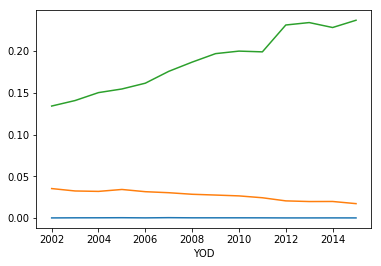

In [83]:
# mesothelioma mortality rates are increasing more sharply for the strata 65+
# falling for 45-65
# pretty flat for 0-44
aa = pd.merge(df.groupby(['YOD', 'AGEGRP2']).COUNT.sum().reset_index(), refpop.groupby(['YEAR', 'AGEGRP2'])['POPULATION'].sum().reset_index())

aa['crude_rate_per_1000'] = (aa['COUNT'] / aa['POPULATION']) * 1000

aa.index = aa.YOD
aa['AGEGRP2'] = aa['AGEGRP2'].astype('str')
aa[aa['AGEGRP2'] == '0']['crude_rate_per_1000'].plot()
aa[aa['AGEGRP2'] == '1']['crude_rate_per_1000'].plot()
aa[aa['AGEGRP2'] == '2']['crude_rate_per_1000'].plot()

In [84]:
aa = pd.merge(df.groupby(['YOD', 'AGEGRP']).COUNT.sum().reset_index(), refpop.groupby(['YEAR', 'AGEGRP'])['POPULATION'].sum().reset_index())
aa['crude_rate_per_1000'] = (aa['COUNT'] / aa['POPULATION']) * 1000
aa.index = aa.YOD

In [85]:
ages = ['15 to 19',
 '20 to 24',
 '25 to 29',
 '30 to 34',
 '35 to 39',
 '40 to 44',
 '45 to 49',
 '50 to 54',
 '55 to 59',
 '60 to 64',
 '65 to 69',
 '70 to 74',
 '75 to 79',
 '80 to 84',
 '85 to 89',
 '90 to 95']

In [86]:
ages1 = ['45 to 49',
 '50 to 54',
 '55 to 59',
 '60 to 64',
 '65 to 69',]
ages2 = [
 '70 to 74',
 '75 to 79',
 '80 to 84',
 '85 to 89',
 '90 to 95']

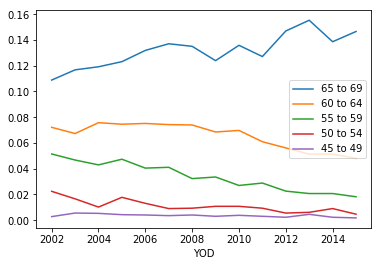

In [87]:
for agegrp in list(reversed(ages1)):
    aa[aa['AGEGRP'] == agegrp]['crude_rate_per_1000'].plot(label=f"{agegrp}", legend=True)

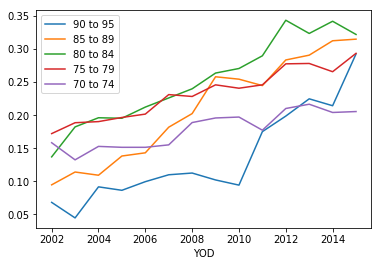

In [88]:
# rates increasing over time most for over 70s
for agegrp in list(reversed(ages2)):
    aa[aa['AGEGRP'] == agegrp]['crude_rate_per_1000'].plot(label=f"{agegrp}", legend=True)

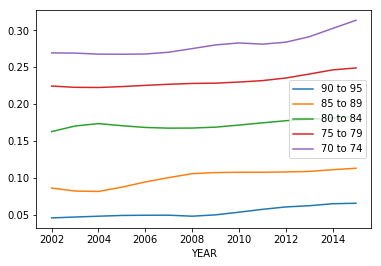

In [89]:
# more over 70s in later years
aa2 = pop_data.groupby(['YEAR', 'AGEGRP'])['POPULATION'].sum().reset_index()
aa2.index = aa2.YEAR
aa2['percent_pop'] = aa2['POPULATION'].map(lambda x: x / float(aa2['POPULATION'].sum()) * 100)

for agegrp in list(reversed(ages2)):
    aa2[aa2['AGEGRP'] == agegrp]['percent_pop'].plot(label=f"{agegrp}", legend=True)

In [90]:
# therefore for directly standardised mortality rate would appear to increasing more sharply
# if pick a later year